## CLIFF - Deconvolution of drug sensitivity into cell-type drug sensitivity

We aimed at integrating drug sensitivity data with cell-type abundance predicted by a bulk deconvolution method - in our case CLIMB method. For this purpose, we developed CLIFF, which deconvolutes the drug sensitivity of cell subtypes. We performed deconvolution of six in vitro mixes containing four human leukemia cell lines (HL60, SUDHL4, K562, and THP1) exposed in parallel to seven drugs commonly used in AML consolidation therapies (5-Aza-2’- deoxycytidine, cytarabine, imatinib, nilotinib, doxorubicin, rapamycin, mitomycin C). To assess the accuracy of CLIFF, we determined cell viability of the four cell lines exposed individually to the same drug panel, doses, and time points

In [33]:
import numpy as np
import pandas as pd
import scipy, sklearn
import math
import os
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
from scipy.stats import spearmanr, pearsonr
from cliff.Cliff import Cliff, Cliff_CV
from cliff.DataContainer import DataContainer
from cliff.utils import sigmoid, rmse

## Define CLIFF method and useful function

The Cliff method is encoded as two class: 

- `DataContainer` : Loads, check and process all data tables necessary for `Cliff` to work
- `Cliff`, `Cliff_CV` : contains the core of the method, which can be run with `run()` function.

## Load expression data

In [2]:
# We load the bulk expression of the mixtures
input_file = 'data/invitro_bulk_expr_cpm.csv'
df_full = pd.read_csv(input_file, delimiter=',', index_col=0)
bulk_expr = df_full.T.iloc[1:7].T
bulk_expr.sort_index(axis=0, inplace=True)

symbol_vec = np.array(df_full.T.iloc[0])
sign_mat = df_full.T.iloc[7:11].T
sign_mat.sort_index(axis=0, inplace=True)

## Load data for a single drug and timepoint as an example run

In [98]:
# This is the true cell line proportions from experiment
W_true = pd.read_csv("data/invitro_true_prop.csv", delimiter = ',', index_col = 0)
W_true

,HL60,K562,SUDHL4,THP1
BULK1,0.2600,0.0900,0.3300,0.3200
BULK2,0.5700,0.1100,0.0700,0.2500
BULK3,0.3333,0.2222,0.0000,0.4444
BULK4,0.0500,0.0400,0.6100,0.3000
BULK5,0.0198,0.3168,0.1881,0.4752
BULK6,0.1200,0.2600,0.2000,0.4200


In [99]:
# This is the CLIMB deconvolution estimate of cell line proportions in bulk
W_single = pd.read_csv("data/invitro_climb_prop.csv", index_col=0)
# We double it to match our drug sensitivity replicates
W_1 = W_single.copy() ; W_1.index = W_single.index + '_n1'
W_2 = W_single.copy() ; W_2.index=W_single.index + '_n2'
W = pd.concat([W_1, W_2]).T ; W = W.iloc[0:4,:]
W

,BULK1_n1,BULK2_n1,BULK3_n1,BULK4_n1,BULK5_n1,BULK6_n1,BULK1_n2,BULK2_n2,BULK3_n2,BULK4_n2,BULK5_n2,BULK6_n2
HL60,0.310084,0.507855,0.341170,0.090203,0.038883,0.136031,0.310084,0.507855,0.341170,0.090203,0.038883,0.136031
K562,0.124323,0.132048,0.162866,0.081004,0.326080,0.270711,0.124323,0.132048,0.162866,0.081004,0.326080,0.270711
SUDHL4,0.240638,0.154503,0.080360,0.528098,0.184536,0.191689,0.240638,0.154503,0.080360,0.528098,0.184536,0.191689
THP1,0.324954,0.205594,0.415604,0.300696,0.450500,0.401569,0.324954,0.205594,0.415604,0.300696,0.450500,0.401569


Subset signature matrix genes to get same gene as in input bulk expression matrix

#### Get drug response data and intersect it with input data

In [108]:
drug = 'Nilotinib'
drug_resp_file = "data/invitro_drug_resp/Y_48h_" + drug + ".csv"
drug_resp = pd.read_csv(drug_resp_file, delimiter=',', index_col=0)
drug_resp_bulk = drug_resp.iloc[8:] # Bulk drug sensitivity data
drug_resp_true = drug_resp.iloc[:8] # cell-type drug sensitivity data (ground truth)
drug_resp_true_norm = pd.DataFrame(np.array([np.clip(x,0.0,1.0) for x in np.array(drug_resp_true)]),
                                   index = drug_resp_true.index, columns = drug_resp_true.columns)
cell_line_name = [x.replace("_n1","",).replace("_n2","",) for x in np.array(drug_resp_true_norm.index)][::2]
drug_resp_true_av = pd.DataFrame(np.array([np.average(np.array(drug_resp_true_norm)[:,x].reshape(-1, 2), axis=1) for x in range(drug_resp_true.shape[1])])).T
drug_resp_true_av.index = cell_line_name ; drug_resp_true_av.columns = drug_resp_true_norm.columns
drug_resp_true_av.sort_index(axis=0, inplace=True)
drug_resp_true_av

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10
HL60,1.0,1.000000,0.993881,0.972028,0.944056,0.918361,0.744210,0.671607,0.810554,0.710319
K562,1.0,0.966292,0.532675,0.137077,0.019948,0.021532,0.002678,0.000000,0.000000,0.005270
SUDHL4,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.921651,0.906214,1.000000,1.000000
THP1,1.0,1.000000,1.000000,0.836382,0.656633,0.579156,0.594995,0.592384,0.524242,0.499507


In [102]:
# The drug sensitivity we want to deconvolution is stored in variable Y
Y = np.array(drug_resp_bulk)
# CLIP y between 0.0 and 1.0 (this should be a probability, but it can happen that this value is superior 
# to 1.0 as it is normalized with respect to the cell survival at dose=0)
Y = np.array([np.clip(x,0.0,1.0) for x in Y])
# Check that we have same sample IDs in same order
all(W.T.columns == sign_mat.columns)

True

We standardize our signature matrix

In [103]:
scaler = StandardScaler()
scaler.fit(sign_mat)
S = scaler.transform(sign_mat)

## Run CLIFF

We first run CLIFF with one single drug (Nilotinib) and one single timepoint (48h) as an example. We will after run all drugs and all timepoints together.

In [104]:
# First, load the data into DataContainer Class
dc = DataContainer(sign_mat, S, np.array(W), Y, n_dose=10)

# Build Cliff object and run it
Cliff_obj = Cliff(dc, n_iter = 100, n_fold_cv = 4, param_C = 30, print_steps=False) # param_C is the regularization parameter, we found it optimal around 30-50
Cliff_obj.run()

Stopping at step 40/100, loss = 0.49498776796623706


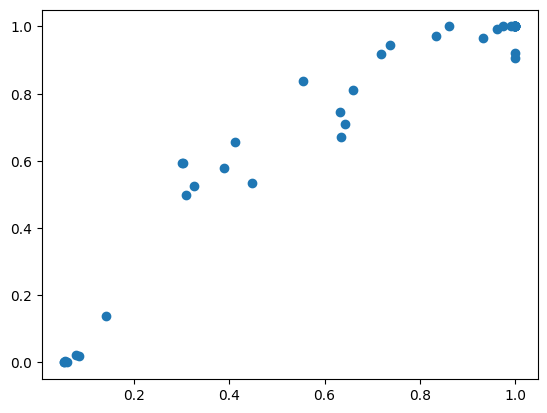

In [105]:
plt.plot(np.array(Cliff_obj.PI).flatten(), np.array(drug_resp_true_av.T).flatten(), 'o')

In [74]:
pearsonr(np.array(Cliff_obj.PI).flatten(), np.array(drug_resp_true_av.T).flatten())

(0.9521775003503141, 3.649573608698712e-21)

Then we can represent the ground truth, experimentally-assessed, cell-line drug sensitivity (left) with the results from the deconvolution algorithm (on the right). 

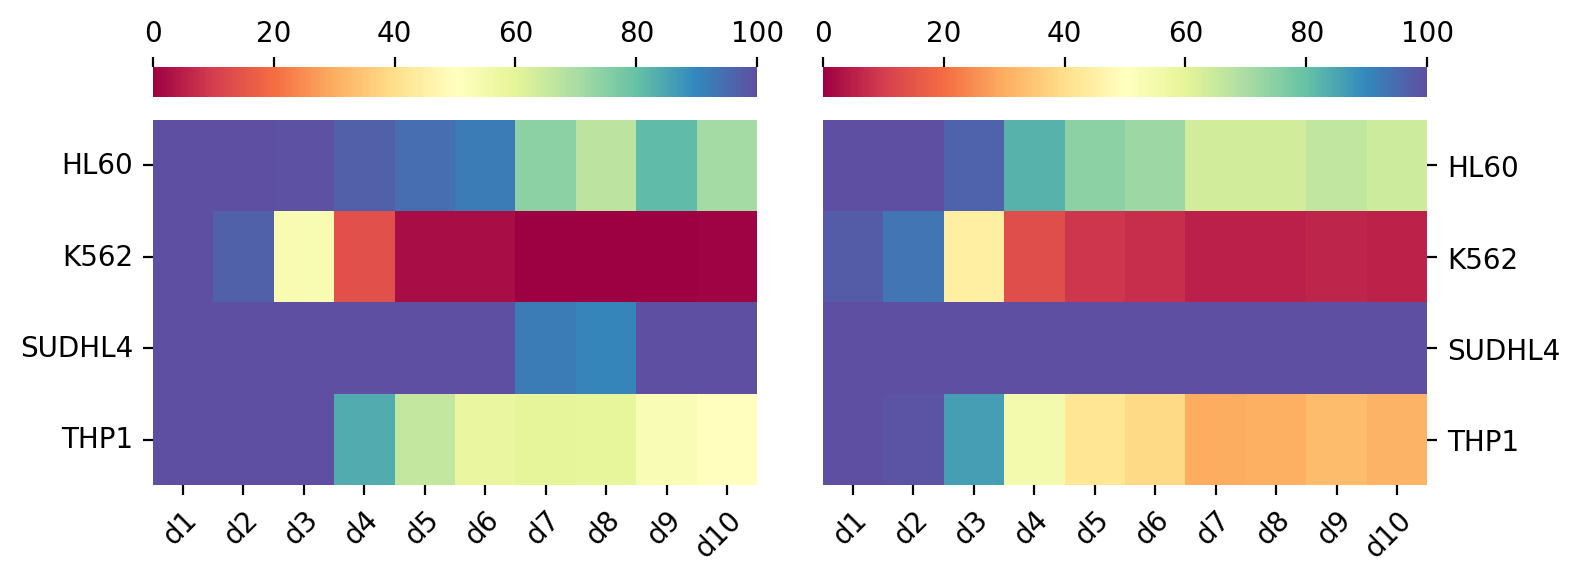

In [75]:
cmap_type = 'Spectral'
fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=200)
sb.heatmap(np.array(drug_resp_true_av)*100, ax=axs[0], vmin=0, vmax=100,  cmap=cmap_type,
           cbar_kws = dict(use_gridspec=True,location="top"))
sb.heatmap(np.array(Cliff_obj.PI.T)*100, ax=axs[1], vmin=0, vmax=100, cmap=cmap_type,
           cbar_kws = dict(use_gridspec=True,location="top"))
axs[0].tick_params(rotation=0) ; axs[1].tick_params(rotation=0)
axs[1].yaxis.tick_right() ; axs[1].tick_params(rotation=0)
axs[1].set_xticklabels(drug_resp_true_av.columns, rotation=45, ha='right', rotation_mode='anchor')
axs[0].set_xticklabels(drug_resp_true_av.columns, rotation=45, ha='right', rotation_mode='anchor')
axs[1].set_yticklabels(drug_resp_true_av.index) ; axs[0].set_yticklabels(drug_resp_true_av.index)
plt.tight_layout()
plt.show()

Of course, we cherry-picked one drug and timepoint that works better than average. We will now run all drugs and timepoints together to have the full picture.

# CLIFF run over all drugs and timepoints 

The following script runs for all timepoints (24h, 48h, and 72h), all drugs (5-Aza-2’- deoxycytidine, cytarabine, imatinib, nilotinib, doxorubicin, rapamycin, mitomycin C), and all doses (0.001, 0.002, 0.007, 0.020, 0.062, 0.198, 0.749, 1.996, 6.238, 19.96 [muM]). 

To make the comparative results between CLIFF+TrueProp, CLIFF+CLIMB, CLIFF+MUSIC, CLIFF+BayesPrism, CLIFF+CiberSortX as in Fig4. F, one needs to run the following loop once for each different cell-line proportions. We provide the processed tables for each of the combination abovementionned.

_Note: The loop takes around 30 minutes to run._

In [86]:
### Define constants ###
drug_indir = 'data/invitro_drug_resp/'
rna_expression_file = 'data/invitro_bulk_expr_cpm.csv'
celltype_prop_file  = 'data/invitro_true_prop.csv'
timepoints = ['48h', '72h', '96h']
list_drugs = ['5Aza2d','Cytarabine','Doxorubicin','Imatinib','Mitomycin','Nilotinib','Oxaliplatin','Rapamycin']
c = 30 # Regularization parameter

In [87]:
### Pre-Processing ### 
# Load bulk RNA-seq and normalize 
df_full = pd.read_csv(rna_expression_file, delimiter=',', index_col=0)
bulk_expr = df_full.T.iloc[1:7].T
bulk_expr.sort_index(axis=0, inplace=True)

# sign_mat is a data.frame containing expression in CPM
symbol_vec = np.array(df_full.T.iloc[0])
sign_mat = df_full.T.iloc[7:11].T
sign_mat.sort_index(axis=0, inplace=True)
# We scale sign_mat values and put them in a S numpy matrix
scaler = StandardScaler()
scaler.fit(sign_mat)
S = scaler.transform(sign_mat)

# Load cell type proportions 
W_single = pd.read_csv(celltype_prop_file, index_col=0)
# We double it to match our drug sensitivity replicates
W_1 = W_single.copy() ; W_1.index = W_single.index+'_n1'
W_2 = W_single.copy() ; W_2.index=W_single.index+'_n2'
W = pd.concat([W_1, W_2]).T ; W = W.iloc[0:4,:]

In [88]:
### Launch Loop over all Drugs and timepoints ###
general_results, list_scor_cell = [], []
for t, timep in enumerate(timepoints):
    list_scor_bulk_d, list_scor_cell_d = [], []
    # iterate over drugs
    for d, drug in enumerate(list_drugs):
        print(drug, timep)
        drug_resp_file = drug_indir + 'Y_' + timep + '_' + drug + ".csv"
        drug_resp_full = pd.read_csv(drug_resp_file, delimiter=',', index_col=0)
        drug_resp = drug_resp_full.iloc[8:]
        drug_resp_true = drug_resp_full.iloc[:8]
        drug_resp_true_norm = pd.DataFrame(np.array([np.clip(x,0.0,1.0) for x in np.array(drug_resp_true)]),
                                   index = drug_resp_true.index, columns = drug_resp_true.columns)
        cell_line_name = [x.replace("_n1","",).replace("_n2","",) for x in np.array(drug_resp_true_norm.index)][::2]
        drug_resp_true_av = pd.DataFrame(np.array([np.average(np.array(drug_resp_true_norm)[:,x].reshape(-1, 2), axis=1) for x in range(drug_resp_true.shape[1])])).T
        drug_resp_true_av.index = cell_line_name
        drug_resp_true_av.columns = drug_resp_true_norm.columns
        drug_resp_true_av.sort_index(axis=0, inplace=True)
        
        y_true = np.array(drug_resp)
        
        # sort all tables and check labels correspondance
        W.sort_index(axis=0, inplace=True)
        W.sort_index(axis=1, inplace=True)
        drug_resp.sort_index(axis=0, inplace=True)
        sign_mat.sort_index(axis=1, inplace=True)

        ### Run CLIFF Deconvolution ### 
        dc = DataContainer(sign_mat, S, np.array(W), y_true, n_dose=10)
        # Make CLIFF object
        Cliff_obj = Cliff(dc, n_iter = 100, n_fold_cv = 4, param_C = c, print_steps=False)
        Cliff_obj.run()

        pi_pred = Cliff_obj.PI
        pi_true = drug_resp_true_av.T

        melt_df = pi_pred.melt() ; melt_df['drug'] = drug
        melt_df['true_d_sens'] = pi_true.melt()['value'] ; melt_df['timepoint'] = timep
        general_results.append(melt_df)

pd_general_results = pd.concat(general_results)
pd_general_results['c_param'] = c

5Aza2d 48h
Stopping at step 6/100, loss = 0.13754645675417812
Cytarabine 48h
Stopping at step 11/100, loss = -0.3052683581423827
Doxorubicin 48h
Stopping at step 10/100, loss = -0.040689573281058614
Imatinib 48h
Stopping at step 18/100, loss = -0.04549681670006237
Mitomycin 48h
Stopping at step 14/100, loss = -0.20362186580822156
Nilotinib 48h
Stopping at step 37/100, loss = 0.46805042687311754
Oxaliplatin 48h
Stopping at step 7/100, loss = -0.7112297472375075
Rapamycin 48h
Stopping at step 15/100, loss = 0.6189893629430391
5Aza2d 72h
Stopping at step 58/100, loss = 0.04814777703566576
Cytarabine 72h
Stopping at step 26/100, loss = -0.3266555271689216
Doxorubicin 72h
Stopping at step 36/100, loss = -0.12065800106912124
Imatinib 72h
Stopping at step 16/100, loss = -0.21130737147933523
Mitomycin 72h
Stopping at step 25/100, loss = -0.45136972003758796
Nilotinib 72h
Stopping at step 26/100, loss = 0.36647456449110805
Oxaliplatin 72h
Stopping at step 5/100, loss = -1.0223839683295888
Rapam

We save the results that will be used in the notebook `cliff_invitro_analysis.ipynb` 

In [89]:
pd_general_results.columns = ['cell_line', 'pred_survival', 'drug', 'true_survival', 'timepoint', 'c_param']

We can then compare the ground truth experimentally-assed cell-line drug sensitivity (x-axis), with the results of CLIFF deconvolution (y-axis), for all drugs and all timepoints :

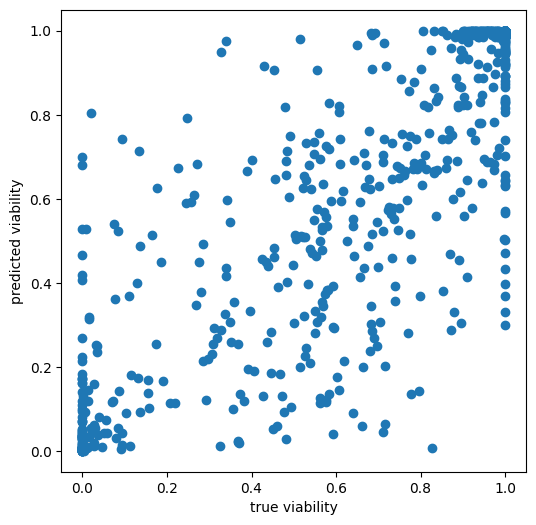

In [90]:
plt.figure(figsize=(6,6))
plt.plot(pd_general_results['true_survival'], pd_general_results['pred_survival'], 'o') 
plt.xlabel('true viability') ; plt.ylabel('predicted viability') ; plt.show()

In [91]:
pearsonr(pd_general_results['true_survival'], pd_general_results['pred_survival'])

(0.886532033411616, 6e-323)

In [92]:
# We write the results which will then be analysed in `cliff_invitro_analysis.ipynb` notebook
pd_general_results.to_csv('data/invitro_cliff_trueprop_predictions.csv', index=None)

Similarly, we can launch the loop above with different cell-type proportions, BayesPrism, CiberSortX, or with the true proportions in W_true. 

In [142]:
def print_bar(percentage):
    for n,num in enumerate(range(0,100,10)):
        print('o', end='') if percentage > num else print('-',end='')